In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## 2. ANNの学習データとして使用する実験データをインポートする　　
input_data_save.txt」の1列目は陽極の気孔率、2列目は陰極の気孔率を表す。 cap_data_save.txt'では、1列目に電池の体積容量が格納されている。

In [2]:
input_data_raw1 = np.loadtxt('data/input_data_save.txt')
cap_data_raw1 = np.loadtxt('data/cap_data_save.txt')

In [3]:
input_data_raw1[:10], cap_data_raw1[:10]

(array([[0.61662566, 0.53994316],
        [0.65760637, 0.42037422],
        [0.30714407, 0.61521121],
        [0.66101914, 0.48977151],
        [0.53456166, 0.4078272 ],
        [0.29389318, 0.6725507 ],
        [0.3753242 , 0.64417427],
        [0.49609668, 0.49757035],
        [0.68087808, 0.53011379],
        [0.68419984, 0.51417012]]),
 array([18.76968 , 16.126228, 16.950027, 16.344672, 18.447988, 15.122456,
        18.833581, 22.453214, 15.263724, 15.075752]))

## 3. Convert the training data to PyTorch tensor format.

In [4]:
x_train_tensor_raw = torch.tensor(input_data_raw1, dtype=torch.float32) 
y_train_tensor_raw = torch.tensor(cap_data_raw1, dtype=torch.float32)   

## 4.Normalize the training data to ensure that the values are within the range [0,1]


In [5]:
def normalize_tensor(tensor,max_val,min_val):
    return (tensor-min_val)/(max_val-min_val)

x_train_epsneg_raw1 = x_train_tensor_raw[:,0]
x_train_epspos_raw1 = x_train_tensor_raw[:,1]

max_epsneg = torch.max(x_train_epsneg_raw1) 
min_epsneg = torch.min(x_train_epsneg_raw1) 
max_epspos = torch.max(x_train_epspos_raw1) 
min_epspos = torch.min(x_train_epspos_raw1)

x_train_epsneg_norm1 =  normalize_tensor(x_train_epsneg_raw1,max_epsneg,min_epsneg) 
x_train_epspos_norm1 =  normalize_tensor(x_train_epspos_raw1,max_epspos,min_epspos) 

x_train = torch.stack((x_train_epsneg_norm1,x_train_epspos_norm1),dim=1)

In [6]:
y_train_tensor = y_train_tensor_raw
max_y = torch.max(y_train_tensor)
min_y = torch.min(y_train_tensor)

y_train_norm = normalize_tensor(y_train_tensor,max_y,min_y)
y_train = y_train_norm.reshape(200,1)

## 5. Set up the ANN machine learning model to represent the relationship between the normalized electrode porosities and the battery areal capacity.

In [7]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 15)  # Input layer (2 inputs) to first hidden layer (15 neurons)
        self.layer2 = nn.Linear(15, 5)  # First hidden layer (15 neurons) to second hidden layer (5 neurons)
        self.layer3 = nn.Linear(5, 1)   # Second hidden layer (5 neurons) to output layer (1 output)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
model = ANN()

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.05)


## 6. Train the ANN machine learning model.

In [8]:
num_epochs = 20000
losses = []
for epoch in range(num_epochs):
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    losses.append(loss.item())

Epoch: 100, Loss: 0.06215800344944
Epoch: 200, Loss: 0.05190829187631607
Epoch: 300, Loss: 0.04140838235616684
Epoch: 400, Loss: 0.03456313908100128
Epoch: 500, Loss: 0.031069230288267136
Epoch: 600, Loss: 0.028677769005298615
Epoch: 700, Loss: 0.026756547391414642
Epoch: 800, Loss: 0.025067472830414772
Epoch: 900, Loss: 0.023527732118964195
Epoch: 1000, Loss: 0.0220213420689106
Epoch: 1100, Loss: 0.020564276725053787
Epoch: 1200, Loss: 0.019117100164294243
Epoch: 1300, Loss: 0.01769166998565197
Epoch: 1400, Loss: 0.016281569376587868
Epoch: 1500, Loss: 0.014861217699944973
Epoch: 1600, Loss: 0.01341191679239273
Epoch: 1700, Loss: 0.011954925023019314
Epoch: 1800, Loss: 0.010552027262747288
Epoch: 1900, Loss: 0.009224498644471169
Epoch: 2000, Loss: 0.008073302917182446
Epoch: 2100, Loss: 0.007068413309752941
Epoch: 2200, Loss: 0.006188134662806988
Epoch: 2300, Loss: 0.005353610962629318
Epoch: 2400, Loss: 0.004577856510877609
Epoch: 2500, Loss: 0.003924360498785973
Epoch: 2600, Loss: 0

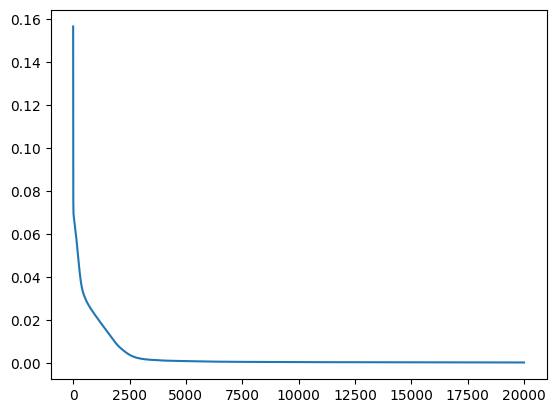

In [9]:
plt.plot(range(num_epochs), losses)

## 7. Set up a gradient-based optimization algorithm to optimize the electrode porosities for achieving the highest battery areal capacity after fast charging, based on the trained ANN surrogate model. Specifically, ensure that the values of the two normalized design variables are within the range [0, 1].

In [10]:
# Define the function to optimize
def objective_function(x):
    tensor1 = x[0]    # 1 represents the anode porosity 
    tensor2 = x[1]    # 2 represents the cathode porosity
    x_input = torch.stack((tensor1, tensor2), dim=0)
    return model(x_input)

# Initialize the inputs (parameters to optimize)
val0 = torch.rand(1)    # an initial guess of anode porosity (normalized)
val1 = torch.rand(1)    # an initial guess of cathode porosity (normalized)
x = torch.tensor([val0, val1], requires_grad=True)

# Define the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD([x], lr=0.01)  # lr is the learning rate

# Number of optimization steps
num_steps = 100

# Lists to store the evolution of x[0], x[1], and loss
x0_values = []
x1_values = []

# Optimization loop
for step in range(num_steps):
    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Compute the objective function
    result = objective_function(x)
    loss = -result[0]

    # Compute the gradients (backward pass)
    loss.backward()

    # Update the parameters using the optimizer
    optimizer.step()

    # Apply the constraints to keep x[0] and x[1] within [0, 1]
    with torch.no_grad():
        x.clamp_(0, 1)  # In-place operation to clamp x within [0, 1]

    # Store the current values of x[0], x[1], and loss
    x0_values.append(x[0].item())
    x1_values.append(x[1].item())

    # Print the current value of the loss and parameters
    print(f"Step {step + 1}: x = {x.detach().numpy()}, Loss = {loss.item()}")

# Final optimized values
print(f"Optimized x: {x.detach().numpy()}")
print(f"Final Loss: {objective_function(x).item()}")


    

Step 1: x = [0.51045734 0.20934434], Loss = -0.429697185754776
Step 2: x = [0.50861776 0.22906056], Loss = -0.468908429145813
Step 3: x = [0.5067782  0.24877678], Loss = -0.5081198215484619
Step 4: x = [0.5049386 0.268493 ], Loss = -0.5473310947418213
Step 5: x = [0.503099  0.2882092], Loss = -0.5865424275398254
Step 6: x = [0.50125945 0.3079254 ], Loss = -0.6257537603378296
Step 7: x = [0.49941987 0.3276416 ], Loss = -0.664965033531189
Step 8: x = [0.4975803 0.3473578], Loss = -0.7041763663291931
Step 9: x = [0.4957407 0.367074 ], Loss = -0.7433876395225525
Step 10: x = [0.49390113 0.38679022], Loss = -0.7825989127159119
Step 11: x = [0.49206156 0.40650642], Loss = -0.8218101859092712
Step 12: x = [0.49022198 0.42622262], Loss = -0.8610213398933411
Step 13: x = [0.49265784 0.4419701 ], Loss = -0.8992739915847778
Step 14: x = [0.4950937 0.4577176], Loss = -0.9246657490730286
Step 15: x = [0.49018407 0.4637813 ], Loss = -0.941878080368042
Step 16: x = [0.48527443 0.469845  ], Loss = -0.

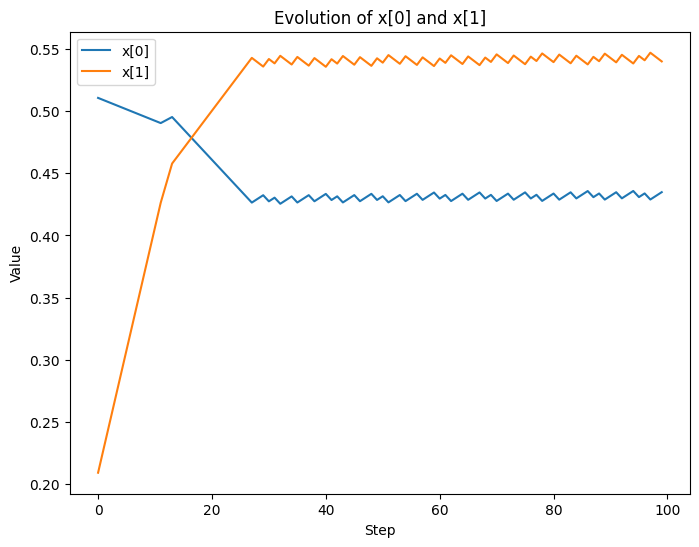

In [11]:
# Plotting the evolution of x[0] and x[1]
plt.figure(figsize=(8, 6))
plt.plot(x0_values, label='x[0]')
plt.plot(x1_values, label='x[1]')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Evolution of x[0] and x[1]')
plt.legend()
plt.show()

In [12]:
# define the de-normalization function
def de_normalize_tensor(tensor, max_val, min_val):
    return tensor * (max_val - min_val) + min_val
    
# de-normalize the porosity of anode and cathode
value_real0 = de_normalize_tensor(x[0], max_epsneg, min_epsneg)
print(value_real0)    # optimized result of anode porosity
value_real1 = de_normalize_tensor(x[1], max_epspos, min_epspos)
print(value_real1)    # optimized result of cathode porosity

# de-normalize the capacity value (C/m^2)
y = model(x)
cap_optim = de_normalize_tensor(y[0], max_y, min_y)
print(cap_optim)

tensor(0.4461, grad_fn=<AddBackward0>)
tensor(0.4959, grad_fn=<AddBackward0>)
tensor(23.5715, grad_fn=<AddBackward0>)
